Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray

Chapter 3: Plotting and visualizing your data with `matplotlib`
===============================================================


## Introduction
[matplotlib](http://matplotlib.org/) is a very powerful plotting library for making amazing visualizations for publications, personal use, or even web and desktop applications. `matplotlib` can create almost any two dimensional visualization you can think of, including histograms, scatter plots, bivariate plots, and image displays. For some inspiration, check out the `matplotlib` [example gallery](http://matplotlib.org/gallery.html) which includes the source code required to generate each example.

## matplotlib API - state-machine versus object-oriented
One part of `matplotlib` that may be initially confusing is that `matplotlib` contains two main methods of making plots - the object-oriented method, and the state-machine method. 
    
A very good overview of the difference between the two usages is provided by [Jake Vanderplas](http://jakevdp.github.io/mpl_tutorial/index.html). Specifically,

+ [Pyplot state-machine](http://jakevdp.github.io/mpl_tutorial/tutorial_pages/tut1.html)
+ [Object-oriented](http://jakevdp.github.io/mpl_tutorial/tutorial_pages/tut2.html)

If you need a primer on matplotlib beyond what is here I suggest: [Python Like you Mean It](https://www.pythonlikeyoumeanit.com/Module5_OddsAndEnds/Matplotlib.html) or the (matplotlib users guide)[https://matplotlib.org/3.0.2/index.html].

In general, you should only use the `pyplot` state-machine environment when plotting data interactively or when developing visualizations for your data. The object-oriented API, while more complicated, is a much more powerful way of creating plots and should be used when developing more complicated visualizations. I always recommend the OO API.

## Image display

We will begin by reading our example image into a NumPy memory array as shown in [Chapter 3](chapter_3_indices.ipynb)

In [128]:
import rasterio
import rasterio.plot

import numpy as np

# Open a raster dataset
dataset = rasterio.open('../../example/LE70220491999322EDC01_stack.gtif')

image = dataset.read()

Let's check out some of this datasets characteristics

In [129]:
# How many bands does this image have?
num_bands = dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# What driver was used to open the raster?
driver = dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = dataset.crs
print('Image projection:')
print(proj)

Number of bands in image: 8

Image size is: 250 rows x 250 columns

Raster driver: GTiff

Image projection:
+init=epsg:32615


Note that if you have the full dataset read in with image = dataset.read() you can do:

In [130]:
red_band = image[2, :, :] # this pulls out the 3rd band
print(red_band.shape)

(250, 250)


This pulls out the band at index 2 which is the 3rd band because python indexing starts at 0

Which is equal to simply doing:

In [131]:
red_band_read = dataset.read(3) # this pulls out the 3rd band
print(red_band_read.shape)

if np.array_equal(red_band_read, red_band): # are they equal?
    print('They are the same.')

(250, 250)
They are the same.


If you have a large dataset the second dataset.read(3) may be preferable because you save on memory.

### Let's calculate NDVI on this dataset

In [137]:
np.seterr(divide='ignore', invalid='ignore')
bandNIR = image[3, :, :]
bandRed = image[2, :, :]

ndvi = (bandNIR.astype(float)-bandRed.astype(float))/(bandNIR.astype(float)+bandRed.astype(float))

In [138]:
print('\nMax NDVI: {m}'.format(m=ndvi.max()))
print('Mean NDVI: {m}'.format(m=ndvi.mean()))
print('Median NDVI: {m}'.format(m=np.median(ndvi)))
print('Min NDVI: {m}'.format(m=ndvi.min()))


Max NDVI: 0.9046013008913515
Mean NDVI: 0.7088133953809207
Median NDVI: 0.7319195214790647
Min NDVI: 0.09470304975922954


With the data read in and NDVI calculated, let's make some plots.

## Basic plotting
First thing to do is to import `matplotlib` into our namespace. I will be using a special feature of the IPython utility which allows me to "inline" `matplotlib` figures by entering the `%matplotlib inline` command. You might also want to try the `nbagg` backend designed specifically for Jupyter notebooks as this backend allows you to interact (pan, zoom, etc) with the plot.

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline

With `matplotlib` imported, we can summon up a figure and make our first plot:

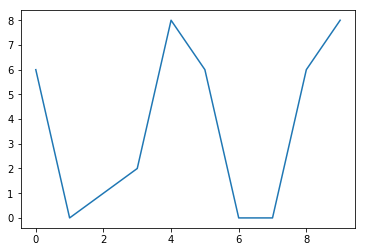

In [140]:
# Array of 0 - 9
x = np.arange(10)
# 10 random numbers, between 0 and 10
y = np.random.randint(0, 10, size=10)

# plot them as lines
plt.plot(x, y)

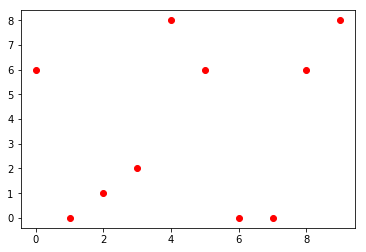

In [141]:
# plot them as just points -- specify "ls" ("linestyle") as a null string
plt.plot(x, y, 'ro', ls='')

We'll be using Matplotib’s object oriented API, instead of its function-based API. Let’s briefly draw a distinction between these two APIs:

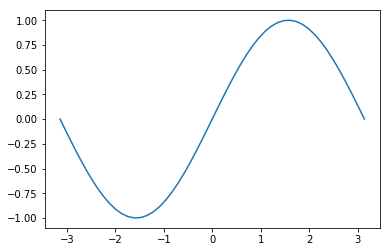

In [142]:
# prepare 50 x-coordinates and 50 y-coordinates
x = np.linspace(-np.pi, np.pi, 50)
y = np.sin(x)

# Plot using matplotlib's functional API:
# a single function call produces a plot; convenient but less flexible
plt.plot(x, y)

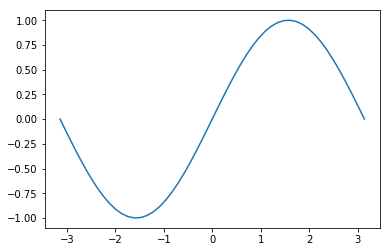

In [143]:
# Plot using matplotlib's object-oriented API:
# we generate a figure and axis object: `fig` and `ax`
fig, ax = plt.subplots()
# we then use these objects to draw-on and manipulate our plot
ax.plot(x, y)

Although the code that invokes the functional API is simpler, it is far less powerful and flexible than the object-oriented API, which produces figure (fig) and axes (ax) objects that we can leverage to customize our plot. You will likely see tutorials utilize the functional API in their examples, so it is useful to understand the distinction here. Shortly, you will learn how to leverage Matplotlib’s object-oriented API in powerful ways.

## Plotting 2D arrays

One typical thing that we might want to do would be to plot one band against another. In order to do this, we will need to transform, or `flatten`, our 2 dimensional arrays of each band's values into 1 dimensional arrays:

In [144]:
print('Array shape before: {shp} (size is {sz})'.format(shp=image[:, :, 3].shape, sz=image[:, :, 3].size))

red = np.ndarray.flatten(bandRed)
nir = np.ndarray.flatten(bandNIR)

print('Array shape after: {shp} (size is {sz})'.format(shp=nir.shape, sz=nir.size))

Array shape before: (8, 250) (size is 2000)
Array shape after: (62500,) (size is 62500)


We have retained the number of entries in each of these raster bands, but we have flattened them from 2 dimensions into 1.

Now we can plot them. Since we just want points, we can use `scatter` for a [scatterplot](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter). Since there are no lines in a scatterplot, it has a slightly different syntax.

Text(0.5, 1.0, 'Tasseled Cap, eh?')

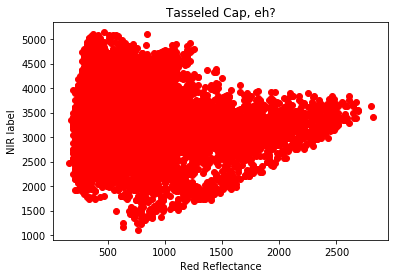

In [148]:
fig, ax = plt.subplots()

# Make the plot
ax.scatter(red, nir, color='r', marker='o')

# Add some axis labels
ax.set_xlabel('Red Reflectance')
ax.set_ylabel('NIR label')

# Add a title
ax.set_title('Tasseled Cap, eh?')

If we wanted the two axes to have the same limits, we can calculate the limits and apply them

Text(0.5, 1.0, 'Tasseled Cap, eh?')

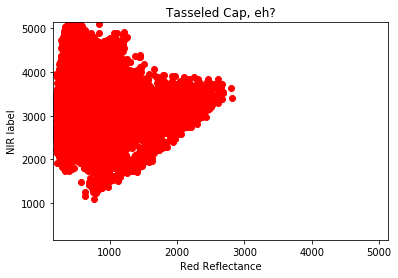

In [150]:
fig, ax = plt.subplots()

# Make the plot
ax.scatter(red, nir, color='r', marker='o')

# Calculate min and max
plot_min = min(red.min(), nir.min())
plot_max = max(red.max(), nir.max())

ax.set_xlim((plot_min, plot_max))
ax.set_ylim((plot_min, plot_max))

# Add some axis labels
ax.set_xlabel('Red Reflectance')
ax.set_ylabel('NIR label')

# Add a title
ax.set_title('Tasseled Cap, eh?')

What if we want to view average intensities for each band?

Text(0.5, 1.0, 'Band Intensities')

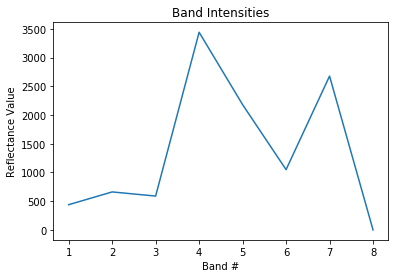

In [153]:
# numbers 1-8
x = np.arange(1,9)
# lets get the average value of each band
y = np.mean(image, axis=(1,2))

fig, ax = plt.subplots()
# plot them as lines
ax.plot(x, y)

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a title
ax.set_title('Band Intensities')

It is common to have this high reflectance in the NIR band (band 4 here) 

## Plotting 2D arrays - images

With so much data available to look at, it can be hard to understand what is going on with the mess of points shown above. Luckily our datasets aren't just a mess of points - they have a spatial structure.

To show the spatial structure of our images, we could make an image plot of one of our bands using `imshow` to [display an image on the axes](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow):

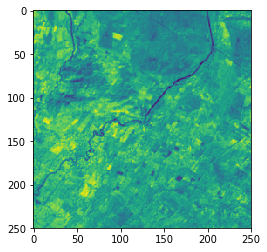

In [158]:
# use the matplotlib.pyplot function "imshow" for an image -- nir at first
fig, ax = plt.subplots()
ax.imshow(image[3, :, :])

Well, it looks like there is something going on - maybe a river in the center and some bright vegetation to the bottom left of the image. What's lacking is any knowledge of what the colors mean.

Luckily, `matplotlib` can provide us a [colorbar](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.colorbar).

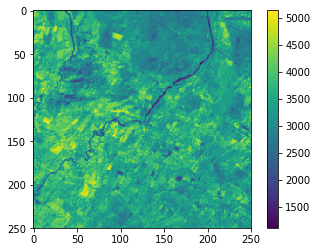

In [165]:
# use "imshow" for an image -- nir at first
fig, ax = plt.subplots()
img = ax.imshow(image[3, :, :])
fig.colorbar(img, ax=ax) # we have to pass the current plot as an argument thus have to set it as a variable

If we want a greyscale image, we can manually specify a [colormap](http://matplotlib.org/api/colors_api.html#matplotlib.colors.Colormap):

We'll also begin showing some more advanced plotting capabilities in matplotlib such as putting multiple plots in a single output.

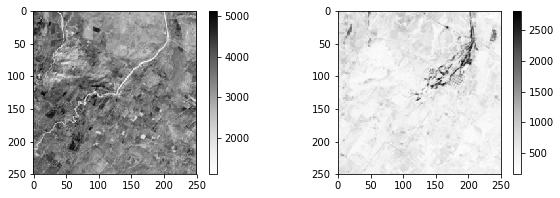

In [174]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3)) # 2 axes on a 1x2 grid
# note that we could also use indexing for our axes:
# fig, ax = plt.subplots(1, 2)
# ax1 = ax[0]

# nir in first subplot
nir = ax1.imshow(image[3, :, :], cmap=plt.cm.Greys)
fig.colorbar(nir, ax=ax1)

# Now red band in the second subplot
red = ax2.imshow(image[2, :, :], cmap=plt.cm.Greys)
fig.colorbar(red, ax=ax2)

## Plotting 3D arrays - multispectral images

Greyscale images are nice, but the most information we can receive comes from looking at the interplay among different bands. To accomplish this, we can map different spectral bands to the Red, Green, and Blue channels on our monitors.

Before we can do this, the `matplotlib` `imshow` help tells us that we need to [normalize](http://en.wikipedia.org/wiki/Normalization_%28image_processing%29) our bands into a 0 - 1 range. To do so, we will perform a simple linear scale fitting 0 reflectance to 0 and 80% reflectance to 1, clipping anything larger or smaller.

    Remember:

    If we are going from a Int16 datatype (e.g., reflectance scaled by 10,000x) to a decimal between 0 and 1, we will need to use a Float!

In [175]:
from rasterio.plot import reshape_as_raster, reshape_as_image

# Extract reference to SWIR1, NIR, and Red bands
index = np.array([4, 3, 2])
colors = image[index, :, :].astype(np.float64)

max_val = 8000
min_val = 0

# Enforce maximum and minimum values
colors[colors[:, :, :] > max_val] = max_val
colors[colors[:, :, :] < min_val] = min_val

for b in range(colors.shape[0]):
    colors[b, :, :] = colors[b, :, :] * 1 / (max_val - min_val)

# rasters are in the format [bands, rows, cols] whereas images are typically [rows, cols, bands]
# and so our array needs to be reshaped
print(colors.shape)
colors_reshaped = reshape_as_image(colors)
print(colors_reshaped.shape)

(3, 250, 250)
(250, 250, 3)


Now that we've got our raster normalized and reshaped let's plot it:

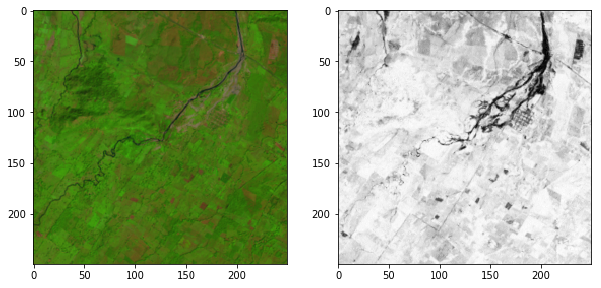

In [176]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 

# Show the color image
axs[0].imshow(colors_reshaped)

# Show NDVI
axs[1].imshow(ndvi, cmap=plt.cm.Greys_r)

### There is a slighly easier way to do this

`rasterio` has its own show function that is built to handle rasters

In [74]:
# these functions build on matplotlib and make them custom for rasterio
from rasterio import plot as rast_plot

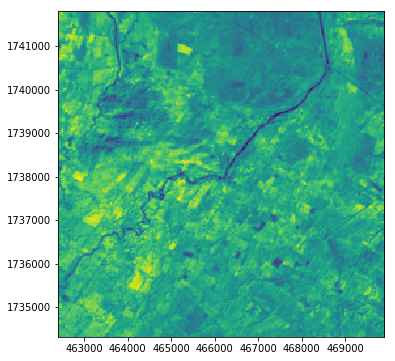

In [184]:
fig, ax = plt.subplots(figsize=(6,6))

# display just band 4 (NIR)
rast_plot.show((dataset, 4), ax=ax)

Add the transform argument to get the plot in geographic coordinates

### And if we want to show a color image we can use rasterio's built in adjust_band function

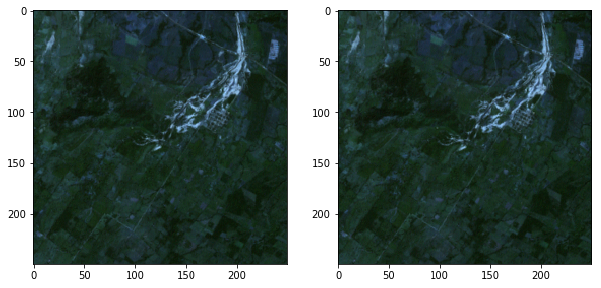

In [189]:
rgb = image[0:3] # read in red, green, blue
rgb_norm = rast_plot.adjust_band(rgb) # normalize bands to range between 1.0 to 0.0
rgb_reshaped = reshape_as_image(rgb_norm) # reshape to [rows, cols, bands]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# the rasterio show function takes in [bands, rows, cols] so we don't need to reshape
rast_plot.show(rgb_norm, ax=axs[0])

# plot with normal matplotlib functions
axs[1].imshow(rgb_reshaped)

### displaying all three bands side by side

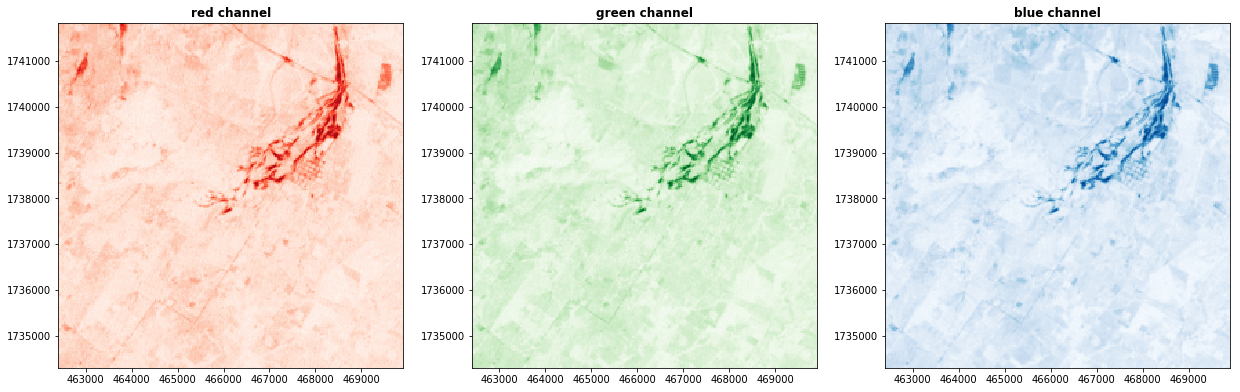

In [86]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
rast_plot.show((dataset, 1), ax=axr, cmap='Reds', title='red channel')
rast_plot.show((dataset, 2), ax=axg, cmap='Greens', title='green channel')
rast_plot.show((dataset, 3), ax=axb, cmap='Blues', title='blue channel')

### If we want to see a histogram of the data we use the show_hist function

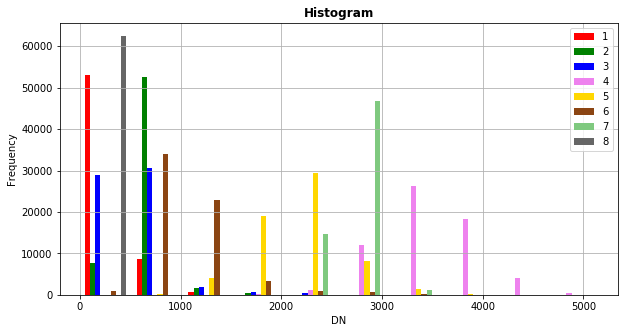

In [186]:
fig, ax = plt.subplots(figsize=(10,5))
rast_plot.show_hist(dataset, ax=ax)

Let's look at an overlapping histogram, maybe that'll be more informative:

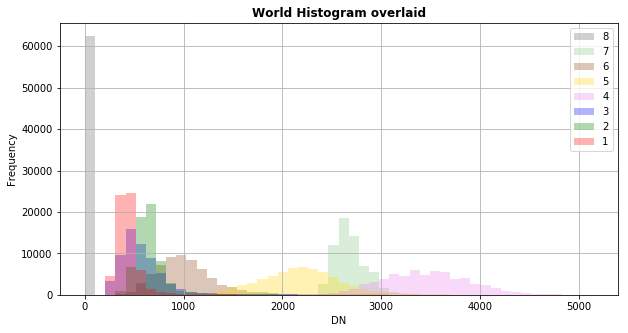

In [99]:
fig, ax = plt.subplots(figsize=(10,5))
rast_plot.show_hist(dataset, ax=ax, bins=50, lw=0.0, stacked=False, alpha=0.3, 
               histtype='stepfilled', title="World Histogram overlaid")

### Let's look at another raster

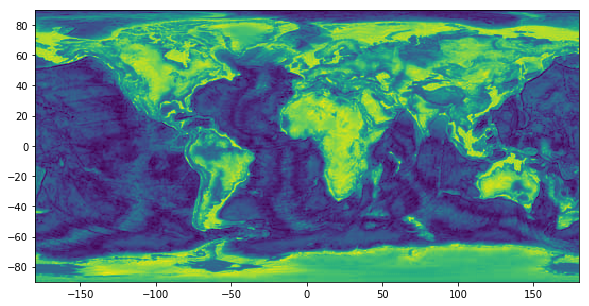

In [100]:
world = rasterio.open("../../example/world.rgb.tif")
fig, ax = plt.subplots(figsize=(10,5))
rast_plot.show((world), ax=ax, cmap='viridis')

### in this one we can also easily show contours from a raster

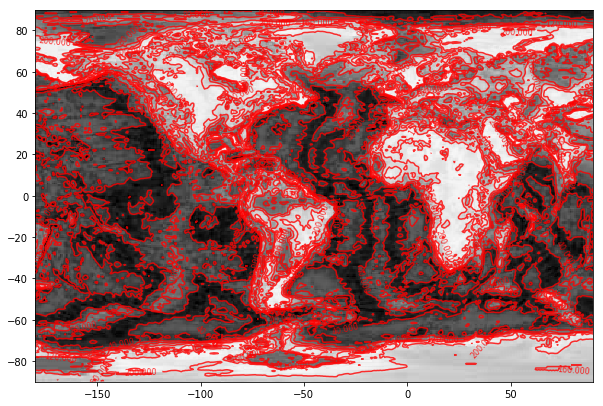

In [101]:
fig, ax = plt.subplots(figsize=(10, 10))
rast_plot.show((world, 1), ax=ax, cmap='Greys_r', interpolation='none')
ax.set_xlim(-180, 90)
ax.set_ylim(-90, 90)

rast_plot.show((world, 1), contour=True, ax=ax)

Check out more documentation for the `rasterio` plotting functions here: https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.show

## Wrapup

We seen how matplotlib can be combined with NumPy and rasterio to easily visualize and explore our remote sensing data. In the next chapter we will cover how to use GDAL's companion library - OGR - to open and read vector data.